In [14]:
%pylab inline

from __future__ import print_function

import os
from src.CAPTCHA_to_signs import DFS

Populating the interactive namespace from numpy and matplotlib


## Preprocess

W tym miejscu chcemy podzielić surowe CAPTCHA ze znanymi etykietami na poszczególne znaki z również znanymi etykietami. Powstały zbiór wykorzystamy do nauki modelu

In [3]:
root_path = os.getcwd()

img_dir_path = os.path.join(root_path, 'data', 'raw')
invalid_img_dir_path = os.path.join(root_path, 'data', 'invalid')
train_img_dir_path = os.path.join(root_path, 'data', 'train')
test_img_dir_path = os.path.join(root_path, 'data', 'test') 

signs_output_dir_path = os.path.join(root_path, 'data', 'signs')

Obrazki, które można dobrze podzielić przenosimy do folderu **train**, a pozostałe do **invalid**

In [6]:
for img_filename in os.listdir(img_dir_path):
    img_path = os.path.join(img_dir_path, img_filename)
    
    label = img_filename.split('.')[0].upper()
    signs = DFS(img_path).dfs_all()
    
    # Przenieś niepoprawne obrazki do folderu invalid
    if len(label) != len(signs):
        invalid_img_path = os.path.join(invalid_img_dir_path, img_filename)
        os.rename(img_path, invalid_img_path)
        continue
        
    # Poprawne przenieś do train
    train_img_path = os.path.join(train_img_dir_path, img_filename)
    os.rename(img_path, train_img_path)

Część obrazków z **train** przenosimy do **test**

In [13]:
import random

# Przenieś część do test
for img_filename in random.sample(os.listdir(train_img_dir_path), 1500):
    img_path = os.path.join(train_img_dir_path, img_filename)
    
    test_img_path = os.path.join(test_img_dir_path, img_filename)
    os.rename(img_path, test_img_path)    

Tworzymy foldery dla wszystkich z mozliwych znaków

In [14]:
for sign in '23456789ABCDEFGHJKLMNPQRSTUVWXYZ':
    sign_dir_path = os.path.join(signs_output_dir_path, sign)
    
    if not os.path.exists(sign_dir_path):
        os.makedirs(sign_dir_path)

Z obrazków ze zbioru trenującego wydzielamy znaki i zapisujemy je w odpowiednim katalogu

In [16]:
from collections import Counter

counter = Counter()

for img_filename in os.listdir(train_img_dir_path):
    img_path = os.path.join(train_img_dir_path, img_filename)
    
    label = img_filename.split('.')[0].upper()
    signs = DFS(img_path).dfs_all()
        
    for sign, target in zip(signs, label):
        counter[target] += 1
        
        sign_path = os.path.join(signs_output_dir_path, target, str(counter[target]))
        sign.save(sign_path)

## Model

Implementacja sieci neuronowej o podstawie dla zbioru MNIST

In [20]:
import keras

from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import CSVLogger, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [6]:
signs_dir_path = os.path.join(root_path, 'data', 'signs')

In [7]:
X, y = [], []

for sign in '23456789ABCDEFGHJKLMNPQRSTUVWXYZ':
    sign_dir_path = os.path.join(signs_dir_path, sign)
    
    for img_filename in os.listdir(sign_dir_path):
        img_path = os.path.join(sign_dir_path, img_filename)
        
        img = image.load_img(img_path, grayscale=True)
        img = image.img_to_array(img)
        
        X.append(img)
        y.append(sign)
        
X, y = np.array(X), np.array(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [37]:
batch_size = 128
num_classes = len('23456789ABCDEFGHJKLMNPQRSTUVWXYZ')
epochs = 10

In [10]:
img_rows, img_cols = 16, 16
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.
X_test /= 255.

In [15]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (21929, 16, 16, 1)
21929 train samples
5483 test samples


In [16]:
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               295040    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [19]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [36]:
model_path = os.path.join(root_path, 'model')
log_path = os.path.join(model_path, 'log')

cur_model = 'simple-model-v1'
csv_logger = CSVLogger(os.path.join(log_path, cur_model + '.log'))

model_file_name= os.path.join(model_path, cur_model + '-{epoch:03d}-{acc:.5f}.h5')
checkpoint = ModelCheckpoint(model_file_name, verbose=0, save_best_only=True)

In [38]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[csv_logger, checkpoint])

Train on 21929 samples, validate on 5483 samples
Epoch 1/10
21929/21929 [==============================] - 3s - loss: 0.0028 - acc: 0.9990 - val_loss: 2.5450e-07 - val_acc: 1.0000
Epoch 2/10
21929/21929 [==============================] - 3s - loss: 0.0025 - acc: 0.9992 - val_loss: 2.5087e-07 - val_acc: 1.0000
Epoch 3/10
21929/21929 [==============================] - 3s - loss: 0.0026 - acc: 0.9992 - val_loss: 2.6676e-07 - val_acc: 1.0000
Epoch 4/10
21929/21929 [==============================] - 3s - loss: 0.0026 - acc: 0.9991 - val_loss: 2.3437e-07 - val_acc: 1.0000
Epoch 5/10
21929/21929 [==============================] - 3s - loss: 0.0020 - acc: 0.9994 - val_loss: 1.9748e-07 - val_acc: 1.0000
Epoch 6/10
21929/21929 [==============================] - 3s - loss: 0.0019 - acc: 0.9994 - val_loss: 2.1631e-07 - val_acc: 1.0000
Epoch 7/10
21929/21929 [==============================] - 3s - loss: 0.0018 - acc: 0.9995 - val_loss: 2.1958e-07 - val_acc: 1.0000
Epoch 8/10
21929/21929 [==========

In [39]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.27305875907e-07
Test accuracy: 1.0


## Predict

Przetestowanie modelu na danych testowych

In [40]:
correct = 0

for img_filename in os.listdir(test_img_dir_path):
    img_path = os.path.join(test_img_dir_path, img_filename)
    
    label = img_filename.split('.')[0].upper()
    signs = DFS(img_path).dfs_all()
    
    signs = np.array([s.bitmap for s in signs]).reshape(-1, 16, 16, 1)
    predict = model.predict_classes(signs, verbose=0)
    
    if label == ''.join(encoder.classes_[predict]):
        correct += 1

In [41]:
acc = correct * 100. / len(os.listdir(test_img_dir_path))
print("Test CAPTCHA dataset accuracy: {}%".format(acc))

Test CAPTCHA dataset accuracy: 100.0%


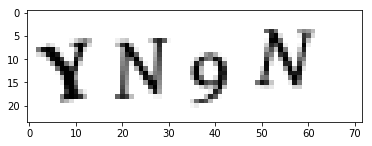

In [54]:
import random

sample_img_filename = random.choice(os.listdir(test_img_dir_path))
sample_img_path = os.path.join(test_img_dir_path, sample_img_filename)

sample_img = imread(sample_img_path)
imshow(sample_img);

Y N 9 N


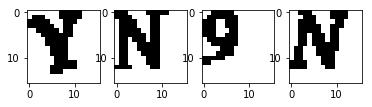

In [69]:
sample_signs = DFS(sample_img_path).dfs_all()

fig, axes = plt.subplots(ncols=len(sample_signs))
for sign, ax in zip(sample_signs, axes):
    ax.imshow(sign.bitmap, cmap='gray')
    
sample_signs_bitmap = np.array([s.bitmap for s in sample_signs]).reshape(-1, 16, 16, 1)
predict = model.predict_classes(sample_signs_bitmap, verbose=0)
print(' '.join(encoder.classes_[predict]))